<a href="https://colab.research.google.com/github/luthierman/quantum-research/blob/main/blackjack_classical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.3.1
!pip install gym

     |████████████████████████████████| 320.4MB 50kB/s 
     |████████████████████████████████| 20.1MB 261kB/s 
     |████████████████████████████████| 460kB 65.2MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1


In [ ]:
import os.path
from os import path
def make_path(p, d):
  print("Checking if {} exists...".format(p+d))
  if path.exists(p+d) == False:
    print("making... new directory")
    os.mkdir(p+str(d))
  print("finished!")
  print(p+str(d))
  return p+str(d)

In [ ]:

import gym
import numpy as np
import random
import matplotlib.pyplot as plt
import math
from collections import deque
import tensorflow as tf
import datetime
import time
class DQN_AGENT(object):
    def __init__(self, action_size, state_size, batch_size, layers):
        self.action_space = action_size
        self.state_space = state_size
        self.layers = layers
        self.q_network = self.make_net(self.state_space, self.layers)
        self.buff = 10000
        self.states = np.zeros((self.buff, self.state_space))
        self.actions = np.zeros((self.buff, 1))
        self.rewards = np.zeros((self.buff, 1))
        self.dones = np.zeros((self.buff, 1))
        self.next_states = np.zeros((self.buff, self.state_space))
        self.counter = 0
        self.batch = batch_size
        # Q Learning Parameters
        self.gamma = 0.95 # DISCOUNT FACTOR, CLOSE TO 1 = LONG TERM
        self.epsilon = 1.0 # Exploration rate
        self.epsilon_decay = 0.9
        self.epsilon_min = 0.01
        self.learning_rate = 3e-3
        self.opt = tf.keras.optimizers.Adam(self.learning_rate)
        self.msbe = None
        #name and path
        self.date = datetime.date.today()
        self.model_name = "CDQN-{date}_{p}_ADAM_lr{lr}_bs{bs}_g{g}_eps{ep}_epsmin{epmin}_epsd{epd}".format(
            date=self.date,
            g=self.gamma, 
            bs=self.batch,
            lr=self.learning_rate,
            p = self.q_network.count_params(),
            ep=self.epsilon,
            epmin=self.epsilon_min,
            epd=self.epsilon_decay)
        
    def make_net(self, state, layers):
        inputs = tf.keras.layers.Input(shape=(state))
        if layers == 1:
          x = tf.keras.layers.Dense(8, activation='relu')(inputs)
        if layers == 2:
          x = tf.keras.layers.Dense(32, activation='relu')(inputs)
        elif layers == 3:
          x = tf.keras.layers.Dense(32, activation='relu')(inputs)
          x = tf.keras.layers.Dense(32, activation='relu')(x)
        x = tf.keras.layers.Dense(self.action_space, name='output')(x)
        model = tf.keras.models.Model(inputs=inputs, outputs=x)
        model.summary()
        return model

    def remember(self, state, action, reward, next_state, done):
        i = self.counter % self.buff
        self.states[i] = state
        self.actions[i] = action
        self.rewards[i] = reward
        self.next_states[i] = next_state
        self.dones[i] = int(done)
        self.counter += 1

    def get_action(self, obs):
        if random.random() < self.epsilon: 
            return np.random.choice(self.action_space)
        else:
            return np.argmax(self.q_network(np.array([obs]))[0])

    def train(self):
        batch_indices = np.random.choice(min(self.counter, self.buff), self.batch)
        state_batch = tf.convert_to_tensor(self.states[batch_indices])
        action_batch = tf.convert_to_tensor(self.actions[batch_indices].flatten(), dtype=tf.int32)
        action_batch = [[i, action_batch[i]] for i in range(len(action_batch))]
        reward_batch = tf.convert_to_tensor(self.rewards[batch_indices], dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_states[batch_indices])
        dones_batch = tf.convert_to_tensor(self.dones[batch_indices], dtype=tf.float32)
        reward_batch = tf.reshape(reward_batch, [len(reward_batch), 1])
        dones_batch = tf.reshape(dones_batch, [len(dones_batch), 1])

        with tf.GradientTape() as tape:
            next_q = self.q_network(next_state_batch)
            y = reward_batch + (1 - dones_batch) * self.gamma * next_q
            q = self.q_network(state_batch, training=True)
            target = tf.reshape(tf.gather_nd(y, action_batch), [self.batch, 1])
            pred = tf.gather_nd(q, action_batch)
            pred = tf.reshape(pred, [self.batch, 1])
            msbe = tf.math.reduce_mean(tf.math.square(target - pred))
            self.msbe = msbe
        grads = tape.gradient(msbe, self.q_network.trainable_variables)
        self.opt.apply_gradients(zip(grads, self.q_network.trainable_variables))
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Hyperparameters
ITERATIONS = 750
batch_size = 64*2*2
windows = 50
learn_delay = 500

env = gym.make("Blackjack-v0")
env.seed(100)
'''env.observation_space.shape'''
print(env.action_space)
print(env.observation_space, env.observation_space.shape)
agent = DQN_AGENT(env.action_space.n, 3, batch_size, 3)
# master_path = make_path("/content/drive/MyDrive/quantum_research/black_jack/classical_models/", agent.model_name)
rewards = []
losses = []
cur_loss = 1
avg_reward = deque(maxlen=ITERATIONS)
best_avg_reward = -math.inf
rs = deque(maxlen=windows)
epi_times = []
start_time = time.process_time()

# for i in range(ITERATIONS):
#     s1 = env.reset()
#     total_reward = 0
#     episode_losses=[]
#     done = False
#     episode_start = time.process_time()
#     while not done:
#         action = agent.get_action(s1)
#         s2, reward, done, info = env.step(action)
#         total_reward += reward
#         agent.remember(s1, action, reward, s2, done)
#         if agent.counter > learn_delay and done:
#             agent.train()
#             episode_losses.append(agent.msbe)
#         if done:
#             rewards.append(total_reward)
#             rs.append(total_reward)
#         s1 = s2
#     avg = np.mean(rs)
#     avg_reward.append(avg)
#     if avg > best_avg_reward:
#         best_avg_reward = avg
#     if len(episode_losses)>0:
#         EPISODE_LOSSES= np.asarray(episode_losses)
#         AVERAGE_EPISODE_LOSS = np.mean(EPISODE_LOSSES)
#         losses.append(AVERAGE_EPISODE_LOSS)
#         cur_loss = AVERAGE_EPISODE_LOSS
#     else:
#         losses.append(cur_loss)
#     epi_end = time.process_time() -episode_start
#     epi_times.append(epi_end)
#     print("\rEpisode {}/{} || Best average reward {}, Current Iteration Reward {}".format(i, ITERATIONS, best_avg_reward, total_reward))
# reward_file = "{h}/rewards".format(h = master_path)
# average_file = "{h}/averages".format(h=master_path)
# times_file = "{h}/times".format(h=master_path)
# loss_file = "{h}/loss".format(h=master_path)
# np.save(reward_file , np.asarray(rewards))
# np.save(average_file , np.asarray(avg_reward))
# np.save(times_file , np.asarray(epi_times))
# np.save(loss_file , np.asarray(losses))
# plt.ylim(-1,1)
# plt.plot(rewards, color='olive', label='Reward')
# plt.plot(avg_reward, color='red', label='Average')
# plt.legend()
# plt.ylabel('Reward')
# plt.xlabel('Generation')
# plt.show()

Discrete(2)
Tuple(Discrete(32), Discrete(11), Discrete(2)) None
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
output (Dense)               (None, 2)                 66        
Total params: 1,250
Trainable params: 1,250
Non-trainable params: 0
_________________________________________________________________


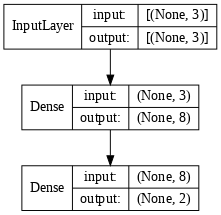

In [ ]:
tf.keras.utils.plot_model(agent1.q_network,
                          show_shapes=True,
                          show_layer_names=False,
                          dpi=70)

In [ ]:
import seaborn as sns
import pandas as pd
def get_data(npath):
  dir = {}
  for i in os.walk(npath):
    if len(i[2])>0 :
      subdir = i[0]+"/"
      data = i[2]
      r = np.load(subdir+data[0])
      ar = np.load(subdir+data[1])
      t = np.load(subdir+data[2])
      l = np.load(subdir+data[3])
      k = i[0].split("/")[-1]
      dir[k]= [r,ar,t,l]
  df = pd.DataFrame(columns = ["model","reward", "ar", "t","loss"])
  for k in dir.keys():
    dfk = pd.DataFrame(np.asarray(dir[k]).T)
    dfk.columns = ["reward", "ar", "t","loss"]
    dfk["model"] = k
    df = pd.concat([df,dfk])
  return df
df = get_data(c_path)

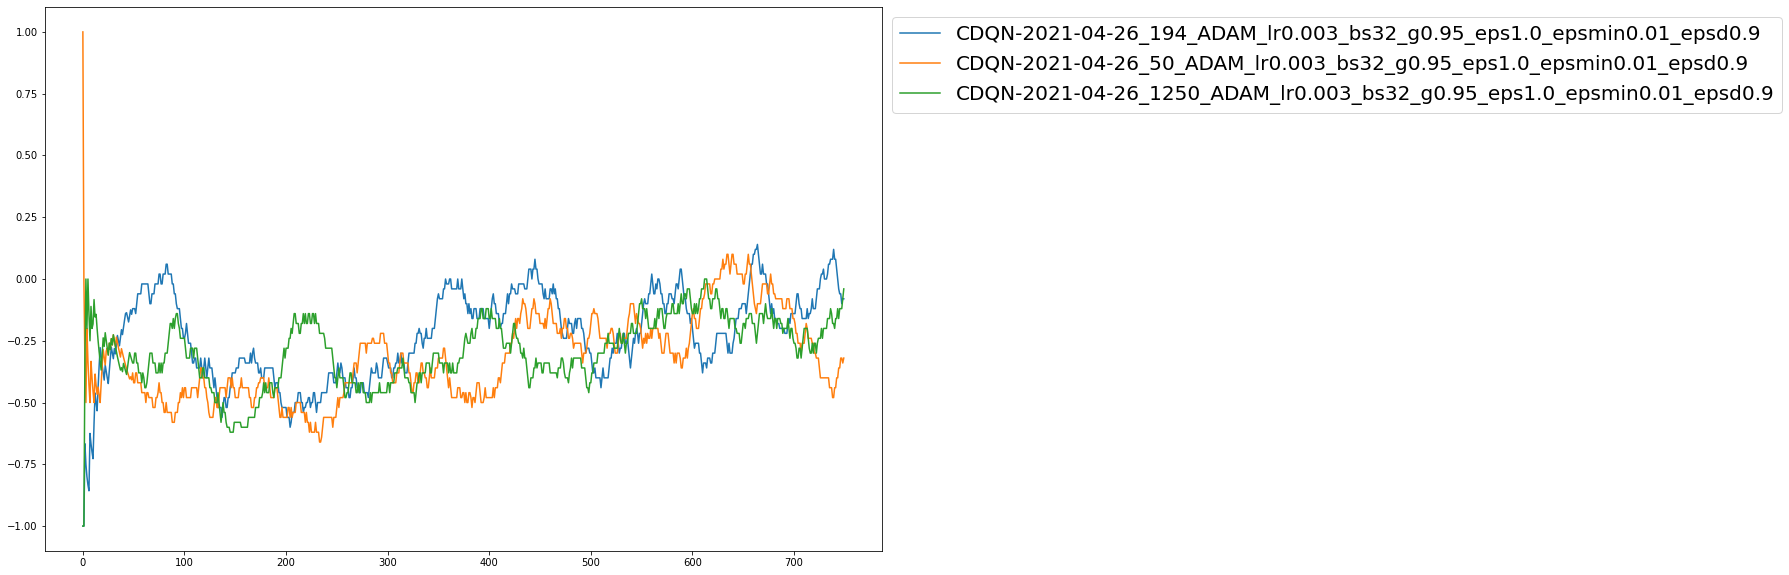

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(15,10))
models = np.asarray(df.model.unique())
i = 0
for m in models[0:3]:
  i +=1
  dfm = df[df.model==m]
  axes.plot(range(750), dfm.ar, label = m)

axes.legend(fontsize=20,loc='upper left', bbox_to_anchor=(1,1))